In [4]:
import tensorflow as tf
import os
import cv2
import random
import numpy as np
from tensorflow.keras import optimizers, layers, models
from matplotlib import pyplot as plt

## Data Prep

In [13]:
image_dir = "images/lattice_points"
train_files = [[], []]

for file in os.listdir(os.path.join(image_dir, "no")):
    if file.endswith(".jpg"):
        train_files[0].append(os.path.join(image_dir, "no", file))

for file in os.listdir(os.path.join(image_dir, "yes")):
    if file.endswith(".jpg"):
        train_files[1].append(os.path.join(image_dir, "yes", file))

In [14]:
all_images = []
all_labels = []

for i in range(2):
    for file in train_files[i]:
        img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        
        img = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)[1]
        img = cv2.Canny(img, 0, 255)
        
        img = img.astype(np.float32) / 255.0
        
        all_images.append(img)
        
        label = [0, 0]
        label[i] = 1
        all_labels.append(label)

all_images = np.array(all_images)[..., np.newaxis]
all_labels = np.array(all_labels)

In [15]:
print(all_images.shape, all_labels.shape)
print(all_images.max())
print(all_labels[0])

(261, 21, 21, 1) (261, 2)
1.0
[1 0]


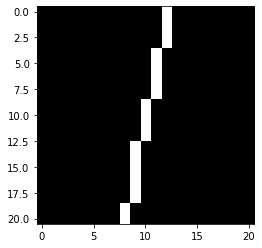

In [16]:
plt.figure()
plt.imshow(all_images[0][:, :, 0], cmap="gray")

In [18]:
train_images = []
train_labels = []
valid_images = []
valid_labels = []

train_indices = random.sample(range(len(all_images)), int(len(all_images) * 0.8))

for i in range(len(all_images)):
    if i in train_indices:
        train_images.append(all_images[i])
        train_labels.append(all_labels[i])
    else:
        valid_images.append(all_images[i])
        valid_labels.append(all_labels[i])

train_images = np.array(train_images)
train_labels = np.array(train_labels)
valid_images = np.array(valid_images)
valid_labels = np.array(valid_labels)

In [27]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=180,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=4,
    height_shift_range=4)

## Initialize Network

In [20]:
model = models.Sequential()
model.add(layers.Dense(441, input_shape=(21, 21, 1)))

for i in range(2):
    for j in [3, 2, 1]:
        model.add(layers.Conv2D(16, j, activation="elu"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.BatchNormalization())
    
model.add(layers.Dense(128, activation="elu"))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())

model.add(layers.Dense(2, activation="softmax"))
model.compile(optimizers.RMSprop(lr=1e-3), loss="categorical_crossentropy", metrics=["categorical_accuracy"])

W0111 13:41:56.233658 4488478144 deprecation.py:506] From /Users/kevin/Library/Python/3.7/lib/python/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 21, 21, 441)       882       
_________________________________________________________________
conv2d (Conv2D)              (None, 19, 19, 16)        63520     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 18, 16)        1040      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 16)        272       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 9, 16)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 9, 16)          64        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 16)          2

In [22]:
def generate_data(train_images, train_labels, batch_size):
    gen = datagen.flow(train_images, train_labels, batch_size=batch_size)
    while True:
        x, y = gen.next()
        yield x, y

In [28]:
batch_size = train_images.shape[0]
epochs = 100

history = model.fit_generator(generate_data(train_images, train_labels, batch_size=batch_size),
                              steps_per_epoch=train_images.shape[0] / batch_size,
                              epochs=epochs, validation_data = (valid_images, valid_labels))

Epoch 1/100
1/1 [==============================] - 1s 825ms/step - loss: 0.3179 - categorical_accuracy: 0.8750 - val_loss: 0.2612 - val_categorical_accuracy: 0.9245
Epoch 2/100
1/1 [==============================] - 1s 687ms/step - loss: 0.3406 - categorical_accuracy: 0.8894 - val_loss: 0.2405 - val_categorical_accuracy: 0.9434
Epoch 3/100
1/1 [==============================] - 1s 657ms/step - loss: 0.2424 - categorical_accuracy: 0.8846 - val_loss: 0.2229 - val_categorical_accuracy: 0.9434
Epoch 4/100
1/1 [==============================] - 1s 653ms/step - loss: 0.2746 - categorical_accuracy: 0.8702 - val_loss: 0.2094 - val_categorical_accuracy: 0.9245
Epoch 5/100
1/1 [==============================] - 1s 647ms/step - loss: 0.3317 - categorical_accuracy: 0.8894 - val_loss: 0.2282 - val_categorical_accuracy: 0.9057
Epoch 6/100
1/1 [==============================] - 1s 651ms/step - loss: 0.2609 - categorical_accuracy: 0.8798 - val_loss: 0.2231 - val_categorical_accuracy: 0.9245
Epoch 7/10

Epoch 51/100
1/1 [==============================] - 1s 725ms/step - loss: 0.2620 - categorical_accuracy: 0.8894 - val_loss: 0.1719 - val_categorical_accuracy: 0.9434
Epoch 52/100
1/1 [==============================] - 1s 712ms/step - loss: 0.2621 - categorical_accuracy: 0.8942 - val_loss: 0.1680 - val_categorical_accuracy: 0.9434
Epoch 53/100
1/1 [==============================] - 1s 810ms/step - loss: 0.2698 - categorical_accuracy: 0.9038 - val_loss: 0.1562 - val_categorical_accuracy: 0.9434
Epoch 54/100
1/1 [==============================] - 1s 752ms/step - loss: 0.2358 - categorical_accuracy: 0.9038 - val_loss: 0.1677 - val_categorical_accuracy: 0.9434
Epoch 55/100
1/1 [==============================] - 1s 825ms/step - loss: 0.2673 - categorical_accuracy: 0.8846 - val_loss: 0.1805 - val_categorical_accuracy: 0.9434
Epoch 56/100
1/1 [==============================] - 1s 668ms/step - loss: 0.2094 - categorical_accuracy: 0.9183 - val_loss: 0.1792 - val_categorical_accuracy: 0.9245
Epoc

In [29]:
model_json = model.to_json()
with open("lattice_points_model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("lattice_points_model.h5")